<a href="https://colab.research.google.com/github/swarnim288/Cancer-detection-for-histologists/blob/main/cancer%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
import random
import scipy.ndimage
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [ ]:
torch.manual_seed(42)

In [ ]:
benign_images=r"/content/drive/MyDrive/New folder/benign"
mal_images=r"/content/drive/MyDrive/New folder/malignant"


In [ ]:
img_gr_cam=r"/content/drive/MyDrive/New folder/benign/SOB_B_A-14-22549AB-400-001.png"

In [ ]:
import os
from PIL import Image

def resize_images_in_folder(folder_path, target_width=224, target_height=224):

    resized_images = []

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            # Construct the full path to the image file
            image_path = os.path.join(folder_path, filename)

            # Open the image
            img = Image.open(image_path)

            # Resize the image
            resized_img = img.resize((target_width, target_height))

            # Append the resized image to the list
            resized_images.append(resized_img)

    return resized_images


In [ ]:
im=Image.open(img_gr_cam)
r_img_g = im.resize((128,128))

In [ ]:
image_gr=np.array(r_img_g)

In [ ]:
ben_img=resize_images_in_folder(benign_images)
mal_img=resize_images_in_folder(mal_images)

In [ ]:
print(len(ben_img))
print(len(mal_img))

588
1232


In [ ]:
import random

def random_oversample(data, target_size):

    # Calculate the current size of the dataset
    current_size = len(data)

    # Calculate the number of samples to add
    samples_to_add = target_size - current_size

    # Check if oversampling is necessary
    if samples_to_add <= 0:
        return data

    # Oversample by randomly selecting samples with replacement
    oversampled_data = data.copy()
    for _ in range(samples_to_add):
        sample = random.choice(data)
        oversampled_data.append(sample)

    return oversampled_data



In [ ]:
ben_img=random_oversample(ben_img,len(mal_img))

In [ ]:
from PIL import Image

def extract_patches(image, patch_size=128, stride=48):

    width = 224
    height=224
    patches = []

    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image.crop((x, y, x + patch_size, y + patch_size))
            patches.append(patch)

    return patches



In [ ]:
img=ben_img[78]
t=extract_patches(img)

NameError: name 'ben_img' is not defined

In [ ]:
print(len(t))

NameError: name 't' is not defined

In [ ]:
ben_patches=[]
for i in ben_img:
  ben_patches.extend(extract_patches(i));


In [ ]:
mal_patches=[]
for i in mal_img:
  mal_patches.extend(extract_patches(i));


In [ ]:
print(len(mal_patches))

11088


In [ ]:
print(len(ben_patches))
print(len(mal_patches))

11088
11088


In [ ]:
array=[]
array.extend(ben_patches)
array.extend(mal_patches)

In [ ]:
print(len(array))

22176


In [ ]:
lab=[]
lab.extend((np.zeros(len(ben_patches))).tolist())
lab.extend((np.ones(len(mal_patches))).tolist())

In [ ]:
print(len(lab))

22176


In [ ]:
def split_data(X, y, test_size=0.007, random_state=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train,X_test,y_train,y_test=split_data(array,lab)

In [ ]:
print(len(X_test))

156


In [ ]:
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),    # Randomly flip images vertically
    transforms.ToTensor(),              # Convert PIL image to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )                                   # Normalize tensor
])


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        target = self.targets[idx]
        target=torch.tensor(target)
        if self.transform:
          image = self.transform(image)
        else:
          image=transforms.ToTensor()(image)
          transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(image)
        return image, target

In [ ]:
train_dataset=CustomDataset(data=X_train,targets=y_train,transform=transform)
test_dataset=CustomDataset(data=X_test,targets=y_test,transform=transform)

In [ ]:
r_img_g_t=torch.tensor(image_gr)

In [ ]:
import torch.nn as nn
from torch.nn import Conv2d, MaxPool2d, Linear, ReLU, Sigmoid


In [ ]:
"""class SimpleConv(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super(SimpleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(out_channels, out_channels*2, kernel_size=3, padding=1)
        self.fc_input_size = self._calculate_fc_input_size()
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def _calculate_fc_input_size(self):

        dummy_input = torch.zeros(1, 3,224, 224)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)  # Flatten along spatial dimensions
        return x.size(1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten along spatial dimensions
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x"""


In [ ]:
#Sconv
import torch.nn.functional as F

class Sconv(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super(Sconv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(out_channels, out_channels*2, kernel_size=3, padding=1)
        self.conv3=nn.Conv2d(out_channels*2,out_channels*4,kernel_size=3, padding=1)
        self.fc_input_size = self._calculate_fc_input_size()
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3=nn.Linear(64,1)
        self.sigmoid = nn.Sigmoid()



    def _calculate_fc_input_size(self):

        dummy_input = torch.zeros(1, 3, 128, 128)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # Flatten along spatial dimensions
        return x.size(1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # Flatten along spatial dimensions
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x



In [ ]:
from torchsummary import summary
model=Sconv()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,856
              ReLU-5          [-1, 128, 64, 64]               0
         MaxPool2d-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         295,168
              ReLU-8          [-1, 256, 32, 32]               0
         MaxPool2d-9          [-1, 256, 16, 16]               0
           Linear-10                  [-1, 128]       8,388,736
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef,roc_curve, auc
val_acc_ep=[]
roc_data=[]
thres_ep=[]
def evaluate_metrics(model, data_loader,criterion):
    with torch.no_grad():
        model.eval()
        predictions = []
        labels = []
        for images, batch_labels in data_loader:
            images = images.to('cuda').float()
            batch_labels = batch_labels.to('cuda').float()
            outputs = torch.sigmoid(model(images))
            predicted = torch.round(outputs)
            predictions.extend(predicted.tolist())
            labels.extend(batch_labels.tolist())

        # loss = criterion(predictions, labels)
        accuracy = accuracy_score(labels, predictions)
        val_acc_ep.append(accuracy)
        precision = precision_score(labels, predictions)
        recall = recall_score(labels, predictions)
        f1 = f1_score(labels, predictions)
        auc_roc = roc_auc_score(labels, predictions)
        auc_pr = average_precision_score(labels, predictions)
        mcc = matthews_corrcoef(labels, predictions)
        fpr, tpr, thresholds = roc_curve(labels, predictions)
        roc_auc = auc(fpr, tpr)
        t=[fpr,tpr]
        roc_data.append(t)
        thres_ep.append(thresholds)
        print("------------------------------------------------VALIDATION SET DATA------------------------------------------------")
        print(f"roc_auc {roc_auc}")
        print(f"Accuracy: {accuracy}")
        # print(f"Loss: {loss}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Sensitivity: {recall}")
        # print(f"Specificity: {specificity}")
        print(f"AUC ROC: {auc_roc}")
        print(f"AUC PR: {auc_pr}")
        print(f"Matthews Correlation Coefficient: {mcc}")

        print("------------------------------------------------VALIDATION SET END DATA------------------------------------------------")

        model.train()

In [ ]:
def acc_make_graphs(train_acc_ep,val_acc_ep):
  epochs = range(1, len(train_acc_ep) + 1)  # Generating epoch numbers

  plt.plot(epochs, train_acc_ep, marker='o', color='blue', label='Training Accuracy')  # Plotting training accuracy vs epochs
  plt.plot(epochs, val_acc_ep, marker='o', color='orange', label='Validation Accuracy')  # Plotting validation accuracy vs epochs

  plt.title('Training and Validation Accuracy per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.xticks(epochs)  # Set x-axis ticks to match epochs
  plt.grid(True)
  plt.legend()  # Show legend
  plt.show()

In [ ]:
def plot_roc_curves(roc_data):
  plt.figure(figsize=(8, 6))  # Set the figure size

  for epoch, data in enumerate(roc_data, start=1):
      fpr_epoch, tpr_epoch = data
      plt.plot(fpr_epoch, tpr_epoch, label=f'Epoch {epoch}')  # Plot ROC curve for current epoch

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot diagonal line for reference
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves for Multiple Epochs')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
"""import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
import os

model = models.mobilenet_v2(pretrained=True)

# Identify the total number of layers in the model
total_layers = len(list(model.children()))

# Replace the classifier layer with a new fully connected layer for binary classification
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)  # Output layer with a single neuron for binary classification

# Freeze all layers except the classifier
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False"""


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 101MB/s] 


In [ ]:
print(model)

Sconv(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
"""from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, input_size=(3, 128, 128))"""

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

100%|██████████| 689/689 [00:38<00:00, 17.99it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.8653846153846153
Accuracy: 0.8653846153846154
Precision: 0.8352941176470589
Recall: 0.9102564102564102
F1 Score: 0.8711656441717791
Sensitivity: 0.9102564102564102
AUC ROC: 0.8653846153846153
AUC PR: 0.8052036199095023
Matthews Correlation Coefficient: 0.7337299020619131
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 1/20 - Train Loss: 0.3983 - Train Accuracy: 0.8263
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:36<00:00, 18.62it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9102564102564104
Accuracy: 0.9102564102564102
Precision: 0.9571428571428572
Recall: 0.8589743589743589
F1 Score: 0.9054054054054054
Sensitivity: 0.8589743589743589
AUC ROC: 0.9102564102564104
AUC PR: 0.8926739926739926
Matthews Correlation Coefficient: 0.8248628195623473
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 2/20 - Train Loss: 0.2875 - Train Accuracy: 0.8811
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:36<00:00, 18.78it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9166666666666666
Accuracy: 0.9166666666666666
Precision: 0.9333333333333333
Recall: 0.8974358974358975
F1 Score: 0.9150326797385621
Sensitivity: 0.8974358974358975
AUC ROC: 0.9166666666666666
AUC PR: 0.8888888888888888
Matthews Correlation Coefficient: 0.8339503888294594
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 3/20 - Train Loss: 0.2381 - Train Accuracy: 0.9027
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:37<00:00, 18.55it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9294871794871795
Accuracy: 0.9294871794871795
Precision: 0.958904109589041
Recall: 0.8974358974358975
F1 Score: 0.9271523178807948
Sensitivity: 0.8974358974358975
AUC ROC: 0.9294871794871795
AUC PR: 0.9118370214260625
Matthews Correlation Coefficient: 0.8607446389919554
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 4/20 - Train Loss: 0.1951 - Train Accuracy: 0.9218
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:37<00:00, 18.54it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9294871794871795
Accuracy: 0.9294871794871795
Precision: 0.935064935064935
Recall: 0.9230769230769231
F1 Score: 0.9290322580645162
Sensitivity: 0.9230769230769231
AUC ROC: 0.9294871794871795
AUC PR: 0.9015984015984017
Matthews Correlation Coefficient: 0.8590449605738679
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 5/20 - Train Loss: 0.1630 - Train Accuracy: 0.9371
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:37<00:00, 18.58it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9551282051282052
Accuracy: 0.9551282051282052
Precision: 0.961038961038961
Recall: 0.9487179487179487
F1 Score: 0.9548387096774195
Sensitivity: 0.9487179487179487
AUC ROC: 0.9551282051282052
AUC PR: 0.9373959373959374
Matthews Correlation Coefficient: 0.9103312268767854
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 6/20 - Train Loss: 0.1408 - Train Accuracy: 0.9455
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:36<00:00, 18.65it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9487179487179487
Accuracy: 0.9487179487179487
Precision: 0.972972972972973
Recall: 0.9230769230769231
F1 Score: 0.9473684210526315
Sensitivity: 0.9230769230769231
AUC ROC: 0.9487179487179487
AUC PR: 0.9365904365904366
Matthews Correlation Coefficient: 0.8986182904354194
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 7/20 - Train Loss: 0.1155 - Train Accuracy: 0.9555
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:36<00:00, 18.64it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9551282051282052
Accuracy: 0.9551282051282052
Precision: 0.9733333333333334
Recall: 0.9358974358974359
F1 Score: 0.954248366013072
Sensitivity: 0.9358974358974359
AUC ROC: 0.9551282051282052
AUC PR: 0.942991452991453
Matthews Correlation Coefficient: 0.9109304247214095
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 8/20 - Train Loss: 0.1098 - Train Accuracy: 0.9586
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:36<00:00, 18.69it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9743589743589743
Accuracy: 0.9743589743589743
Precision: 1.0
Recall: 0.9487179487179487
F1 Score: 0.9736842105263158
Sensitivity: 0.9487179487179487
AUC ROC: 0.9743589743589743
AUC PR: 0.9743589743589743
Matthews Correlation Coefficient: 0.9499679070317291
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 9/20 - Train Loss: 0.0877 - Train Accuracy: 0.9677
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:37<00:00, 18.51it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9551282051282051
Accuracy: 0.9551282051282052
Precision: 1.0
Recall: 0.9102564102564102
F1 Score: 0.953020134228188
Sensitivity: 0.9102564102564102
AUC ROC: 0.9551282051282051
AUC PR: 0.9551282051282051
Matthews Correlation Coefficient: 0.9139442639718567
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 10/20 - Train Loss: 0.0739 - Train Accuracy: 0.9738
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:37<00:00, 18.30it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9487179487179488
Accuracy: 0.9487179487179487
Precision: 0.9375
Recall: 0.9615384615384616
F1 Score: 0.9493670886075949
Sensitivity: 0.9615384615384616
AUC ROC: 0.9487179487179488
AUC PR: 0.9206730769230769
Matthews Correlation Coefficient: 0.8977310580745098
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 11/20 - Train Loss: 0.0604 - Train Accuracy: 0.9790
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:37<00:00, 18.58it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9807692307692308
Accuracy: 0.9807692307692307
Precision: 0.987012987012987
Recall: 0.9743589743589743
F1 Score: 0.9806451612903225
Sensitivity: 0.9743589743589743
AUC ROC: 0.9807692307692308
AUC PR: 0.9745254745254746
Matthews Correlation Coefficient: 0.9616174931797029
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 12/20 - Train Loss: 0.0542 - Train Accuracy: 0.9806
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:37<00:00, 18.51it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9743589743589743
Accuracy: 0.9743589743589743
Precision: 1.0
Recall: 0.9487179487179487
F1 Score: 0.9736842105263158
Sensitivity: 0.9487179487179487
AUC ROC: 0.9743589743589743
AUC PR: 0.9743589743589743
Matthews Correlation Coefficient: 0.9499679070317291
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 13/20 - Train Loss: 0.0449 - Train Accuracy: 0.9838
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:36<00:00, 18.71it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9935897435897436
Accuracy: 0.9935897435897436
Precision: 0.9873417721518988
Recall: 1.0
F1 Score: 0.9936305732484078
Sensitivity: 1.0
AUC ROC: 0.9935897435897436
AUC PR: 0.9873417721518988
Matthews Correlation Coefficient: 0.9872606263311616
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 14/20 - Train Loss: 0.0437 - Train Accuracy: 0.9859
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:37<00:00, 18.59it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Sensitivity: 1.0
AUC ROC: 1.0
AUC PR: 1.0
Matthews Correlation Coefficient: 1.0
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 15/20 - Train Loss: 0.0358 - Train Accuracy: 0.9886
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:38<00:00, 18.12it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9935897435897436
Accuracy: 0.9935897435897436
Precision: 0.9873417721518988
Recall: 1.0
F1 Score: 0.9936305732484078
Sensitivity: 1.0
AUC ROC: 0.9935897435897436
AUC PR: 0.9873417721518988
Matthews Correlation Coefficient: 0.9872606263311616
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 16/20 - Train Loss: 0.0273 - Train Accuracy: 0.9910
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:36<00:00, 18.84it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9935897435897436
Accuracy: 0.9935897435897436
Precision: 1.0
Recall: 0.9871794871794872
F1 Score: 0.9935483870967742
Sensitivity: 0.9871794871794872
AUC ROC: 0.9935897435897436
AUC PR: 0.9935897435897436
Matthews Correlation Coefficient: 0.9872606263311616
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 17/20 - Train Loss: 0.0268 - Train Accuracy: 0.9910
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:36<00:00, 18.70it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9871794871794872
Accuracy: 0.9871794871794872
Precision: 1.0
Recall: 0.9743589743589743
F1 Score: 0.9870129870129869
Sensitivity: 0.9743589743589743
AUC ROC: 0.9871794871794872
AUC PR: 0.9871794871794872
Matthews Correlation Coefficient: 0.9746794344808963
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 18/20 - Train Loss: 0.0203 - Train Accuracy: 0.9933
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:36<00:00, 18.91it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9935897435897436
Accuracy: 0.9935897435897436
Precision: 1.0
Recall: 0.9871794871794872
F1 Score: 0.9935483870967742
Sensitivity: 0.9871794871794872
AUC ROC: 0.9935897435897436
AUC PR: 0.9935897435897436
Matthews Correlation Coefficient: 0.9872606263311616
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 19/20 - Train Loss: 0.0251 - Train Accuracy: 0.9919
----------------------------------------------------------------------------------------------------


100%|██████████| 689/689 [00:36<00:00, 18.79it/s]


------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.9871794871794872
Accuracy: 0.9871794871794872
Precision: 0.9871794871794872
Recall: 0.9871794871794872
F1 Score: 0.9871794871794872
Sensitivity: 0.9871794871794872
AUC ROC: 0.9871794871794872
AUC PR: 0.9809335963182118
Matthews Correlation Coefficient: 0.9743589743589743
------------------------------------------------VALIDATION SET END DATA------------------------------------------------
Epoch 20/20 - Train Loss: 0.0211 - Train Accuracy: 0.9928
----------------------------------------------------------------------------------------------------


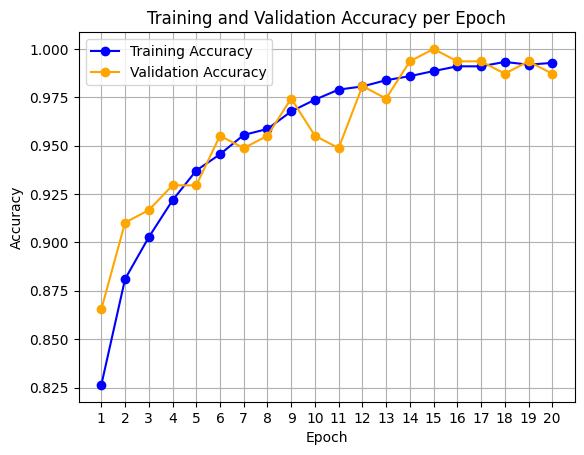

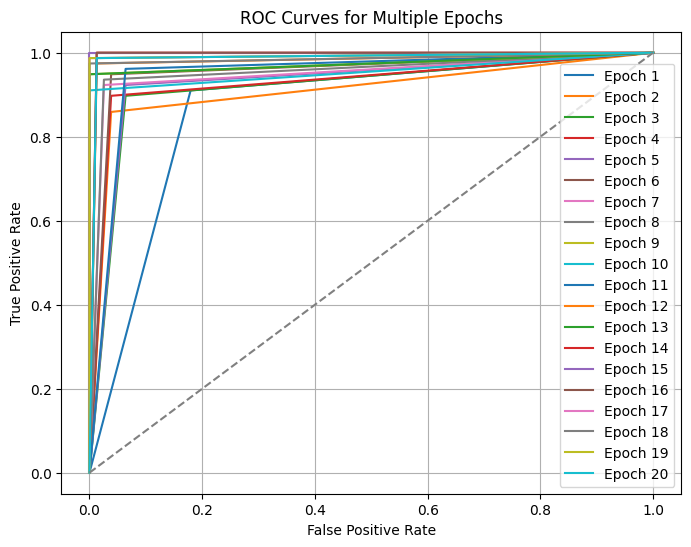

In [ ]:
# import os
from tqdm import tqdm
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
device = 'cuda'
EPOCHS =  20 #8-78-20. 6-76-10. #35
model =  Sconv()
criterion = nn.BCELoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=True)
train_loss_ep=[]
train_acc_ep=[]
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    train_correct = 0


    for images, labels in tqdm(train_loader):
        images = images.to(device).float()

        # convert labels to long tensor
        labels = labels.to(device).unsqueeze(1).float()

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(torch.sigmoid(outputs), labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_correct += ((torch.sigmoid(outputs) > 0.5)*1 == labels).sum().item()

    train_accuracy = train_correct / len(train_dataset)
    train_acc_ep.append(train_accuracy)
    average_train_loss = total_train_loss / len(train_loader)
    train_loss_ep.append(average_train_loss)
    evaluate_metrics(model,test_loader,criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {average_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
    print("--"*50)
acc_make_graphs(train_acc_ep,val_acc_ep)
plot_roc_curves(roc_data)

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/model.pth')

In [ ]:
from google.colab import files
files.download('/content/drive/My Drive/model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(len(train_acc_ep))
print(len(val_acc_ep))

23
47


In [ ]:
test_ben_images=r"/content/drive/MyDrive/New folder (1)/benign_200"
test_mal_images=r"/content/drive/MyDrive/New folder (1)/malignant_200"

In [ ]:
def resize_images_in_folder(folder_path, target_width=128, target_height=128):

    resized_images = []

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            # Construct the full path to the image file
            image_path = os.path.join(folder_path, filename)

            # Open the image
            img = Image.open(image_path)

            # Resize the image
            resized_img = img.resize((target_width, target_height))

            # Append the resized image to the list
            resized_images.append(resized_img)

    return resized_images


testing 200X

In [ ]:
ben_img2=resize_images_in_folder(test_ben_images)
mal_img2=resize_images_in_folder(test_mal_images)

In [ ]:
array2=[]
array2.extend(ben_img2)
array2.extend(mal_img2)

In [ ]:
lab2=[]
lab2.extend((np.zeros(len(ben_img2))).tolist())
lab2.extend((np.ones(len(mal_img2))).tolist())

In [ ]:
test_dataset=CustomDataset(data=array2,targets=lab2,transform=transform)

In [ ]:
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=True)

In [ ]:
evaluate_metrics(model,test_loader,criterion)

------------------------------------------------VALIDATION SET DATA------------------------------------------------
roc_auc 0.8479924246798388
Accuracy: 0.8604073522106309
Precision: 0.9141150112023898
Recall: 0.8805755395683453
F1 Score: 0.897031879809454
Sensitivity: 0.8805755395683453
AUC ROC: 0.8479924246798388
AUC PR: 0.8874113033203967
Matthews Correlation Coefficient: 0.6817591453045174
------------------------------------------------VALIDATION SET END DATA------------------------------------------------


In [ ]:
image_gr_t=torch.tensor(image_gr)
image_gr_t = image_gr_t.permute(2, 1, 0)
print(image_gr_t.shape)
image_gr_t=transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(image_gr_t.float())


torch.Size([3, 128, 128])


In [ ]:
image2=(image_gr_t.unsqueeze(0))

In [ ]:
print(image2.shape)

torch.Size([1, 3, 128, 128])


GRAD CAM - ON SCONV()

In [ ]:
pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
image_gr_rgb=image_gr.astype(np.float32)/255.0

In [ ]:
model.cpu()

Sconv(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
target_layers = [model.conv3]
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=image2)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image_gr_rgb, grayscale_cam, use_rgb=True)


In [ ]:
print(visualization.shape)

(128, 128, 3)


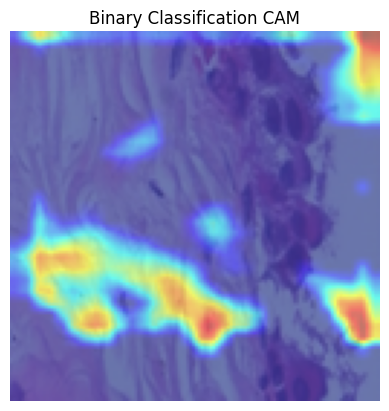

In [ ]:
plt.imshow(visualization)
plt.axis('off')
plt.title('Binary Classification CAM')
plt.show()

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

def generate_visualizations(model, rgb_images, target_layers, preprocess, use_cuda=True):
    """
    Generate visualizations for a list of RGB images using GradCAM.

    Parameters:
        model (torch.nn.Module): Pre-trained model.
        rgb_images (list): List of RGB images (PIL format).
        target_layers (list): List of target layers for GradCAM.
        preprocess (torchvision.transforms.Compose): Preprocessing transform.
        use_cuda (bool): Whether to use CUDA for computations. Default is True.

    Returns:
        list: List of tensor objects.
    """

    model.eval()

    # List to store the visualizations
    visualizations = []

    # Iterate through the list of RGB images
    for rgb_image in rgb_images:
        # Convert PIL image to tensor and apply preprocessing
        image_tensor = preprocess(rgb_image).unsqueeze(0)

        # Initialize GradCAM object
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)

        # Generate GradCAM
        grayscale_cam = cam(input_tensor=image_tensor)
        grayscale_cam = grayscale_cam[0, :]

        # Convert the original image to a numpy array
        rgb_img = np.array(rgb_image).astype(np.float32) / 255

        # Create visualization object
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Append visualization to the list
        visualizations.append(visualization)

    return visualizations


In [ ]:
def generate_visualizations(model, rgb_images, target_layers, preprocess, use_cuda=True):
    """
    Generate and print visualizations for a list of RGB images using GradCAM.

    Parameters:
        model (torch.nn.Module): Pre-trained model.
        rgb_images (list): List of RGB images (PIL format).
        target_layers (list): List of target layers for GradCAM.
        preprocess (torchvision.transforms.Compose): Preprocessing transform.
        use_cuda (bool): Whether to use CUDA for computations. Default is True.

    Returns:
        None
    """
    # Set the model to evaluation mode
    model.eval()

    # Define device
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

    # List to store the visualizations
    visualizations = []

    # Iterate through the list of RGB images
    for rgb_image in rgb_images:
        # Convert PIL image to tensor and apply preprocessing
        image_tensor = preprocess(rgb_image).unsqueeze(0).to(device)

        # Initialize GradCAM object
        cam = GradCAM(model=model.to(device), target_layers=target_layers)

        # Generate GradCAM
        grayscale_cam = cam(input_tensor=image_tensor)
        grayscale_cam = grayscale_cam[0, :]

        # Convert the original image to a numpy array
        rgb_img = np.array(rgb_image).astype(np.float32) / 255.0

        # Create visualization object
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Append visualization to the list
        visualizations.append(visualization)

    # Print the visualizations
    for idx, visualization in enumerate(visualizations):
        plt.figure()
        plt.imshow(visualization)
        plt.axis('off')
        plt.title(f'Visualization {idx+1}')
        plt.show()


In [ ]:
rgb_images=[r_img_g]
preprocess = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

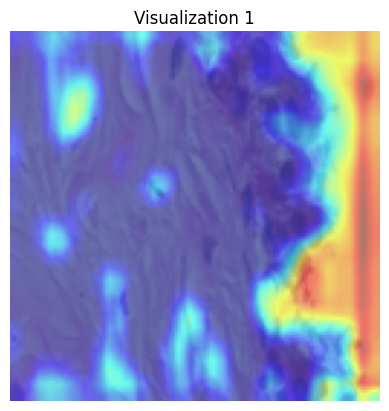

In [ ]:


# Example usage:
# Assume 'model', 'rgb_images', 'target_layers', and 'preprocess' are defined elsewhere
generate_visualizations(model, rgb_images, target_layers,preprocess,use_cuda=True )


In [ ]:
img_p=r"/content/drive/MyDrive/New folder/malignant/SOB_M_DC-14-10926-400-001.png"

In [ ]:

im=Image.open(img_p)
im_l=[im.resize((128,128))]

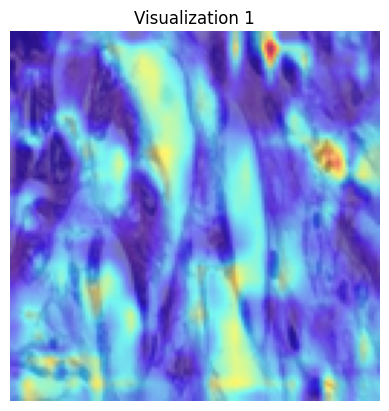

In [ ]:
generate_visualizations(model,im_l, target_layers,preprocess,use_cuda=False )

In [ ]:
def draw_bounding_boxes_on_heatmap(heatmap, image, threshold=0.5):
    # Normalize the heatmap
    heatmap = cv2.normalize(heatmap, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    # Threshold the heatmap
    _, thresh = cv2.threshold(heatmap, threshold, 1, type=cv2.THRESH_BINARY)
    thresh = np.uint8(thresh * 255)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes on the original image
    image_with_boxes = image.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return image_with_boxes

# Draw bounding boxes
image_with_boxes = draw_bounding_boxes_on_heatmap(grayscale_cam, np.array(image))

# Display the image with bounding boxes
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Heatmap')
plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image with Bounding Boxes')
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


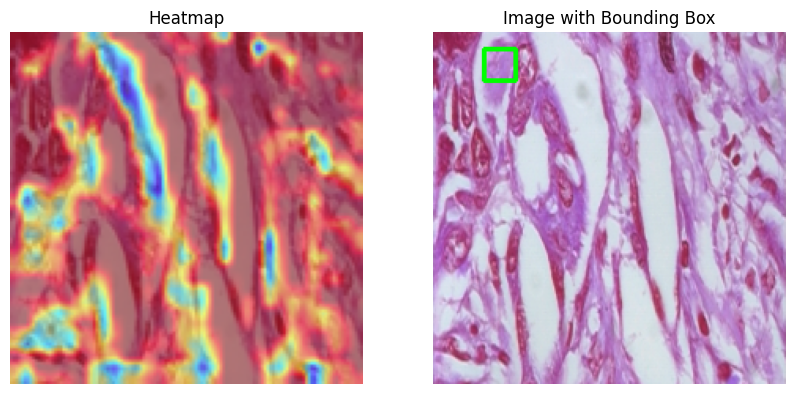

In [ ]:
model.eval()

# Load and preprocess the input image
image_path =r"/content/drive/MyDrive/New folder/malignant/SOB_M_DC-14-10926-400-001.png" # Update with the path to your image
image = Image.open(image_path)
im=image.resize((128,128))
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Create Grad-CAM object
target_layer = model.conv3  # The last convolutional layer of resnet50
cam = GradCAM(model=model, target_layers=[target_layer])

# Generate Grad-CAM heatmap
target_category = None  # Set to the desired class index if you have one
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension

# Convert the original image to numpy array
image_np = np.array(im) / 255.0  # Normalize to [0, 1] range

# Overlay the heatmap on the image
cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

# Function to draw a bounding box around the maximum value in the heatmap
def draw_bounding_box_on_max_heatmap(heatmap, image, box_size=20):
    # Find the coordinates of the maximum value in the heatmap
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(heatmap)

    # Define the top-left and bottom-right points of the bounding box
    x, y = max_loc
    x1, y1 = max(0, x - box_size // 2), max(0, y - box_size // 2)
    x2, y2 = min(heatmap.shape[1], x + box_size // 2), min(heatmap.shape[0], y + box_size // 2)

    # Draw the bounding box on the original image
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return image_with_box

# Draw bounding box around the maximum value
image_with_box = draw_bounding_box_on_max_heatmap(grayscale_cam, np.array(image))

# Display the image with bounding box
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Heatmap')
plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image with Bounding Box')
plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [ ]:
# Import Grad-CAM library
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Load a pre-trained model and set it to evaluation mode

model.eval()

# Load and preprocess the input image
image_path = "path_to_your_image.jpg"  # Update with the path to your image
image = Image.open(image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Create Grad-CAM object
target_layer = model.layer4[-1]  # The last convolutional layer of resnet50
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

# Generate Grad-CAM heatmap
target_category = None  # Set to the desired class index if you have one
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension

# Convert the original image to numpy array
image_np = np.array(image) / 255.0  # Normalize to [0, 1] range

# Overlay the heatmap on the image
cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

# Function to draw a bounding box around the maximum value in the heatmap
def draw_bounding_box_on_max_heatmap(heatmap, image, box_size=20):
    # Find the coordinates of the maximum value in the heatmap
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(heatmap)

    # Define the top-left and bottom-right points of the bounding box
    x, y = max_loc
    x1, y1 = max(0, x - box_size // 2), max(0, y - box_size // 2)
    x2, y2 = min(heatmap.shape[1], x + box_size // 2), min(heatmap.shape[0], y + box_size // 2)

    # Draw the bounding box on the original image
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return image_with_box

# Draw bounding box around the maximum value
image_with_box = draw_bounding_box_on_max_heatmap(grayscale_cam, np.array(image))

# Display the image with bounding box
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Heatmap')
plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image with Bounding Box')
plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()